In [352]:
from __future__ import division
import os
import urllib, cStringIO
import pymongo as pm ## first establish ssh tunnel to server where database is running
import base64
import numpy as np
from numpy import *
import PIL
from PIL import Image
import base64
import matplotlib
%matplotlib inline
from matplotlib import pylab, mlab, pyplot
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches
import cv2
import pandas as pd
from svgpathtools import parse_path
import svg_distance_helpers as rsh
import svg_render_helpers as rrh
import torch
from torch.autograd import Variable



NameError: name 'sys' is not defined

#### directory and file hierarchy

In [2]:
# directory & file hierarchy
analysis_dir = os.getcwd()
tracing_ref_pixel = os.path.join(analysis_dir, 'tracing_ref_pixel')
tracing_ref_svg = os.path.join(analysis_dir, 'tracing_ref_svg')
data_dir = os.path.join(analysis_dir,"trace_test")

canvas_side = 432 # image size
rows, cols = canvas_side, canvas_side # the size of a given drawing image

In [ ]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']

#### Get SVG data

In [ ]:
# test on a specific square with one stroke
imrecs = coll.find({'$and':[{'category':'square'},{'dataType':'finalImage'}, {'sessionId':'cdm_run_v31525889224904'}]}).sort('time')
print imrecs.count()

## retrieve example square tracing from db
imrec = imrecs[0] 

In [ ]:
reload(rsh)
## get list of vertices and codes for tracing 
try:
    ## get the corresponding stroke records for this tracing
    stroke_recs = coll.find({'$and': [{'sessionId':imrec['sessionId']}, 
                                      {'dataType':'stroke'},
                                      {'trialNum': imrec['trialNum']}]}).sort('time')

    print 'Number of strokes in this tracing: {}'.format(stroke_recs.count())    
    
    ## check to make sure that there is at least one stroke! 
    if stroke_recs.count()>0:

        ## now make an svg list!
        svg_list = rsh.make_svg_list(stroke_recs)

        ## get verts and codes in all strokes
        ## both verts_list and codes_list are 2D list. Each sublist represent a stroke
        verts_list, codes_list = rsh.get_verts_and_codes(svg_list)
        
        ## Convert multiple strokes into one stroke
        
        
except Exception as e:
    print 'Oops, something went wrong! Here is the error:'  
    print e
    pass        

#### Tracing/Copying Error Calculation 

In [4]:
# change names. only for testing purpose
for index, imgfile in enumerate(os.listdir(data_dir)):
    new_filename = 'test{:02}.png'.format(index)
    os.rename(os.path.join(data_dir,imgfile), os.path.join(data_dir,new_filename))

In [333]:
reload(rsh)
# get tracings from the data folder
#for file in os.listdir(data_dir):

# read in tracing and reference files
fpath = os.path.join(data_dir, 'test23.png')
img_draw = cv2.resize(cv2.imread(fpath),(200, 200))
img_draw = rsh.color_to_num(img_draw)
print len(rsh.find_black_pixels(img_draw))

square_ref_file = os.path.join(tracing_ref_pixel, 'square_200.png')
img_ref = cv2.imread(square_ref_file)
img_ref = rsh.color_to_num(img_ref, threshold=0, white_background=False)
print len(rsh.find_black_pixels(img_ref))
# 1733 1344


1733
1344


In [342]:
reload(rsh)
loss, final_draw, product, weights, bias = rsh.minimize_error_gradient(img_ref, img_draw)
print loss
print weights
print bias

epoch 0, loss -0.0319378525019
epoch 100, loss -0.035124078393
epoch 200, loss -0.0351846069098
epoch 300, loss -0.03515169397
epoch 400, loss -0.0351790301502
epoch 500, loss -0.0351502560079
epoch 600, loss -0.035154171288
epoch 700, loss -0.0351744368672
epoch 800, loss -0.0351398587227
epoch 900, loss -0.0351506285369
tensor(-0.0352, grad_fn=<ThAddBackward>)
Parameter containing:
tensor([[1.0246, 0.0686],
        [0.0909, 1.0091]], requires_grad=True)
Parameter containing:
tensor([-2.0007, -0.0012], requires_grad=True)


In [343]:
print final_draw

tensor([[ 32.5934, 104.3702],
        [ 32.6621, 105.3793],
        [ 32.7307, 106.3884],
        ...,
        [197.9622, 110.0126],
        [198.0308, 111.0217],
        [198.0995, 112.0308]], grad_fn=<ThAddmmBackward>)


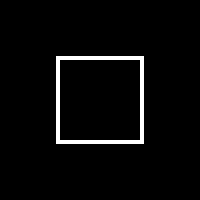

In [344]:
img_ref_ = img_ref *255
im3 = Image.fromarray(np.uint8(img_ref_))
im3

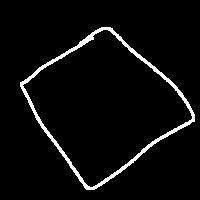

In [345]:
img_draw_ = img_draw *255
im2 = Image.fromarray(np.uint8(img_draw_))
im2

In [346]:
final = np.round(product.detach().numpy())

In [347]:
_final = final*255

In [348]:
im = Image.fromarray(np.uint8(_final))

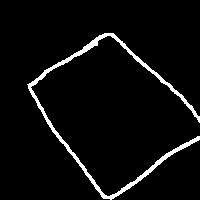

In [349]:
im

In [332]:
reload(rsh)
# ref = np.array([[0,0,0,1,0,0,1], [0,0,0,1,0,0,1], [0,0,0,1,0,0,1], [0,0,0,1,0,0,1]])
# draw = np.array([[0,0,0,1,0,0,1], [0,0,0,1,0,0,1], [0,0,0,1,0,0,1], [0,0,0,1,0,0,1]])

ref = np.array([[0,0,1],[0,0,1], [0,0,0]])
draw = np.array([[0,1,0],[0,1,0],[0,0,0]])

# ref = np.array([[0, 0, 0],[0, 1, 1],[0, 0, 0]])
# draw = np.array([[0, 1, 1],[0, 0, 0], [0, 0, 0]])

loss, final_draw, product, weights, bias = rsh.minimize_error_gradient(ref, draw)
print weights
print bias
print product
print final_draw

epoch 0, loss -0.193274140358
epoch 100, loss -6.01577377319
epoch 200, loss -6.7850317955
epoch 300, loss -5.45942926407
epoch 400, loss -6.00580120087
epoch 500, loss -7.43549633026
epoch 600, loss -7.74732685089
epoch 700, loss -6.12330675125
epoch 800, loss -7.63179159164
epoch 900, loss -7.57773017883
Parameter containing:
tensor([[0.8577, 1.0500],
        [0.3603, 2.1361]], requires_grad=True)
Parameter containing:
tensor([-0.9500,  1.1361], requires_grad=True)
tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 0.]], grad_fn=<RoundBackward>)
tensor([[0.1000, 3.2722],
        [0.9577, 3.6325]], grad_fn=<ThAddmmBackward>)


In [284]:
print product

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 0.]], grad_fn=<RoundBackward>)


#### preprocessing of tracing and visualization (if desired)


In [ ]:
reallyRun = 1
if reallyRun:
    rsh.plot_shape(verts_list, codes_list, canvas_side)
    #rsh.plot_stroke(verts_list[1], codes_list[1], canvas_side)

#### Prepare human rating

In [59]:
data = pd.DataFrame(os.listdir(data_dir))
data.columns = ['image_id']
data.to_csv(os.path.join(analysis_dir,'performance.csv'))

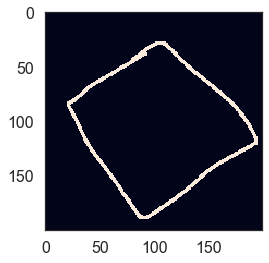

kp []
des None


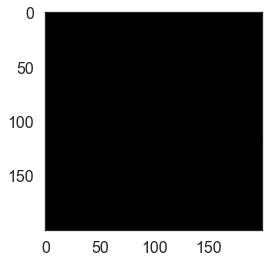

(<matplotlib.image.AxesImage at 0x1a19577250>, None)

In [232]:
# Initiate ORB detector
orb = cv2.ORB()
# find the keypoints with ORB
kp = orb.detect(img_draw, None)
print 'kp', kp
# compute the descriptors with ORB
kp, des = orb.compute(img_draw, kp)
print 'des', des
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img_draw, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

In [ ]:
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(dsp1, dsp2, None)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)
 

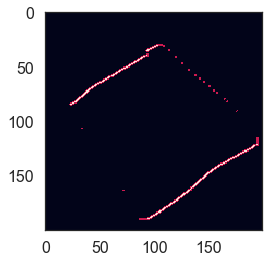

(<matplotlib.image.AxesImage at 0x1a19a69ad0>,
 <function matplotlib.pyplot.show>)

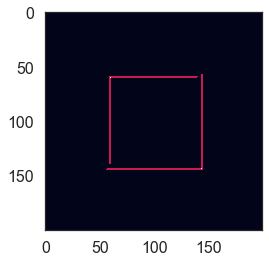

In [251]:
draw_gabor = np.zeros(img_draw.shape)
ref_gabor = np.zeros(img_ref.shape)
ksize = 3
gabor_kernel = cv2.getGaborKernel((ksize, ksize), 4.0, 180, 10.0, 0.5)
draw_gabor = cv2.filter2D(img_draw,-1, gabor_kernel)
ref_gabor = cv2.filter2D(img_ref, -1, gabor_kernel)
plt.imshow(draw_gabor), plt.show()
plt.imshow(ref_gabor), plt.show


(1, 1, 200, 200)


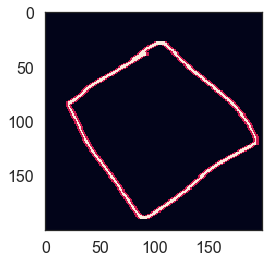

(1, 1, 200, 200)


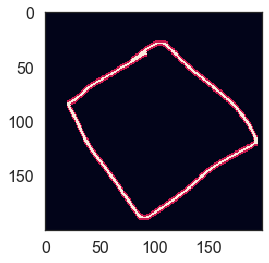

tensor([[ 26, 101],
        [ 26, 102],
        [ 26, 103],
        ...,
        [190,  92],
        [190,  93],
        [190,  94]]) tensor([[ 26, 101],
        [ 26, 102],
        [ 26, 103],
        ...,
        [190,  92],
        [190,  93],
        [190,  94]])


In [282]:
reload(rsh)
img_x = rsh.partial_x(torch.tensor(img_draw, dtype=torch.float))
print img_x.numpy().shape
plt.imshow(img_x.numpy()[0][0]), plt.show()

img_y = rsh.partial_y(torch.tensor(img_draw, dtype=torch.float))
print img_y.numpy().shape
plt.imshow(img_y.numpy()[0][0]), plt.show()

grad,theta = rsh.gradient(torch.tensor(img_draw, dtype=torch.float))
print grad.nonzero(), theta.nonzero()